# 🌟 Análise de Sentimentos para Iniciantes — Usando Base MySQL + BERTimbau + Visualizações + Interface Gradio

Este notebook foi criado especialmente para **usar sua base local MySQL**:

**Banco:** `vendas_ouvidoria`

**Tabela:** `interacoes`

**Colunas:** `id`, `id_cliente`, `descricao` (texto para análise de sentimentos)

### O que você aprenderá:
- Conectar ao MySQL e carregar dados reais
- Preparar e explorar textos
- Visualizar nuvens de palavras e frequências
- Treinar um modelo moderno em português (**BERTimbau**)
- Avaliar desempenho
- Criar uma **interface web interativa** com Gradio para testar o modelo

⚠️ Necessário: rodar em ambiente com GPU (Google Colab, Paperspace etc.).

## 1. Importar bibliotecas

In [1]:
import torch

import gradio            as gr
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt

from wordcloud               import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics         import classification_report
from transformers            import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets                import Dataset
from sqlalchemy              import create_engine
from transformers            import pipeline


## 2. Conectar ao MySQL e carregar a tabela

In [3]:
# --- Configurações do seu banco de dados MySQL ---
host = 'localhost'                   # Ou o IP/hostname do seu servidor MySQL
port = 3306                          # Porta padrão do MySQL
usuario = 'root'                     # Seu usuário do MySQL   
senha = 'root'                       # Sua senha do MySQL
database = 'vendas_ouvidoria' # O banco de dados que você quer usar
engine = create_engine(
    f"mysql+pymysql://{usuario}:{senha}@{host}:{port}/{database}",
    pool_recycle=3600, # Recicla conexões a cada 1 hora (3600 segundos)
    pool_pre_ping=True # Testa a conexão antes de usá-la no pool
)
query = 'SELECT id, id_cliente, descricao FROM interacoes;'
df =  pd.read_sql_query(query, engine)
df.head()

,id,id_cliente,descricao
0,1,28,"""Olá! Estou muito descontente com o atendiment..."
1,2,1330,Oi! Eu solicitei o pedido 1330 para o produto ...
2,3,418,"""Estou muito descontente com o atendimento da ..."
3,4,1599,"""Estou muito desapontado com a experiência que..."
4,5,3310,"""Olá, eu comprei o EcoTank L4260 e estou muito..."


## 3. Exploração inicial dos textos

In [4]:
df['descricao'] = df['descricao'].astype(str)
df.describe(include='all')

,id,id_cliente,descricao
count,159453.000000,159453.000000,159453
unique,NaN,NaN,159121
top,NaN,NaN,Subject: Re: Order Issue with PlayStation VR2 ...
freq,NaN,NaN,2
mean,79554.284736,267854.864073,NaN
std,45936.291025,153599.833584,NaN
min,1.000000,7.000000,NaN
25%,39778.000000,135129.000000,NaN
50%,79549.000000,268302.000000,NaN
75%,119338.000000,400607.000000,NaN


### Distribuição de tamanho dos textos

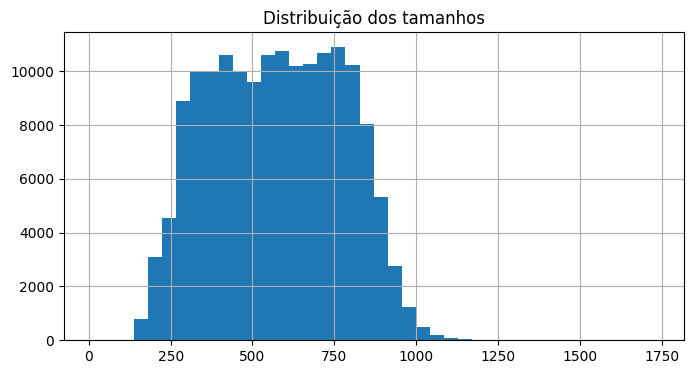

In [5]:
df['tamanho'] = df['descricao'].apply(len)
df['tamanho'].hist(bins=40, figsize=(8,4))
plt.title('Distribuição dos tamanhos')
plt.show()

### Nuvem de palavras (WordCloud)

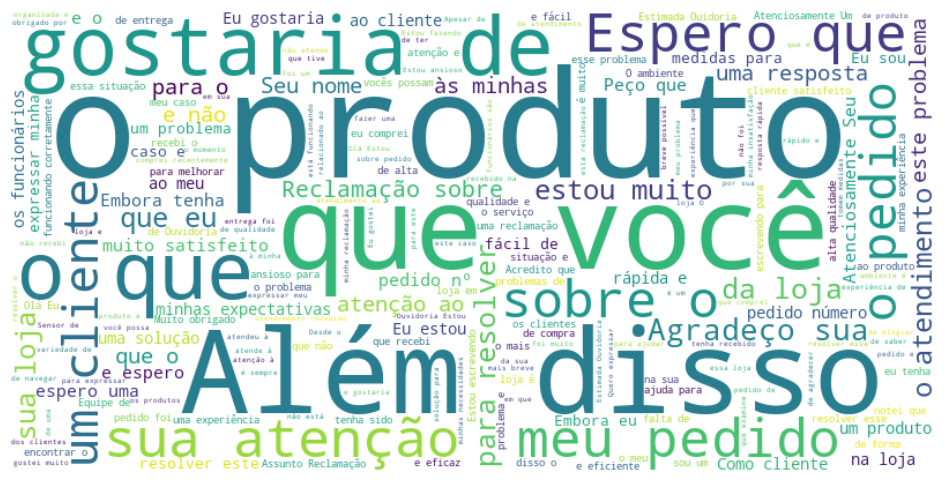

In [6]:
texto = ' '.join(df['descricao'])
wc = WordCloud(width=800, height=400, background_color='white').generate(texto)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## 4. Como treinar: precisamos de rótulos
Seu banco **não possui uma coluna com sentimento**. Para treinar um modelo supervisionado, precisamos disso.

### Opção 1 — Criar uma coluna `sentimento` manualmente
Você pode criar em sua tabela ou gerar aqui uma coluna simulada.

### Opção 2 — Usar um modelo pré-treinado para gerar rótulos iniciais
Vamos seguir pela **opção 2**, usando um modelo pronto para gerar rótulos iniciais.

In [1]:
from transformers import pipeline
import torch

# verifica se há GPU
device = 0 if torch.cuda.is_available() else -1
print("DISPOSITIVO USADO:", "GPU" if device == 0 else "CPU")

# cria o pipeline já carregando o modelo na GPU
rotulador = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    device=device
)

def gerar_rotulo(texto):
    try:
        # limita texto a 500 chars
        pred = rotulador(texto[:500])[0]['label']

        # nlptown retorna algo como "1 star", "2 stars"...
        estrela = int(pred.split()[0])

        if estrela <= 2:
            return 0
        elif estrela == 3:
            return 1
        else:
            return 2
    except:
        return 1  # neutro se der erro

df['sentimento'] = df['descricao'].apply(gerar_rotulo)
df.head()


DISPOSITIVO USADO: CPU


Device set to use cpu


NameError: name 'df' is not defined

## 5. Separar treino e teste

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentimento'])
train_df.shape, test_df.shape

## 6. Carregar o **BERTimbau**

In [ ]:
modelo_nome = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(modelo_nome)
model = AutoModelForSequenceClassification.from_pretrained(modelo_nome, num_labels=3)

## 7. Converter para Dataset Hugging Face

In [ ]:
train_ds = Dataset.from_pandas(train_df[['descricao','sentimento']])
test_ds = Dataset.from_pandas(test_df[['descricao','sentimento']])
# Para o dataset de treino
train_ds = train_ds.rename_column("sentimento", "labels")
# Para o dataset de teste
test_ds = test_ds.rename_column("sentimento", "labels")

### O que é a Biblioteca `datasets` do Python?

Em sua essência, a biblioteca `datasets` é uma **solução unificada para carregar, pré-processar, compartilhar e manipular conjuntos de dados para tarefas de Machine Learning (ML)**. Ela fornece uma API padronizada para acessar milhares de conjuntos de dados disponíveis publicamente no Hugging Face Hub, além de permitir que você crie e gerencie seus próprios conjuntos de dados.

#### Por que usar a Biblioteca `datasets`?

*   **Acesso a uma Vasta Coleção de Dados:** O Hugging Face Hub hospeda milhares de conjuntos de dados para diversas tarefas (PLN, visão computacional, áudio, etc.) em múltiplos idiomas. A biblioteca `datasets` permite carregá-los com uma única linha de código.
*   **Eficiência para Grandes Dados:** Ela é otimizada para lidar com datasets que não cabem completamente na memória RAM. Isso é feito através de:
    *   **Mapeamento de memória (memory-mapping):** Os dados são lidos diretamente do disco conforme necessário, sem carregar tudo para a RAM.
    *   **Carregamento lazy (lazy loading):** Apenas as partes do dataset que estão sendo usadas são carregadas, não o conjunto inteiro.
    *   **Streaming:** Permite processar datasets gigantes sem precisar baixá-los completamente.
*   **Pré-processamento Otimizado:** Oferece ferramentas eficientes para pré-processar os dados, como a função `map()`, que pode aplicar transformações em lotes (batch processing) e usar processamento paralelo (multiprocessing) para acelerar operações.
*   **API Padronizada:** Independentemente da origem ou do formato original do dataset (JSON, CSV, Parquet, texto puro, etc.), a biblioteca `datasets` o apresenta em uma estrutura de dados consistente, facilitando o trabalho.
*   **Integração com Frameworks de ML:** Permite converter facilmente os conjuntos de dados para formatos compatíveis com PyTorch, TensorFlow e JAX.
*   **Gerenciamento de Versões e Cachê:** Os datasets baixados são automaticamente armazenados em cache, e a biblioteca gerencia diferentes versões, garantindo reprodutibilidade e evitando downloads redundantes.

#### Principais Funcionalidades:

*   **`load_dataset()`:** A função central para carregar qualquer dataset do Hugging Face Hub ou de arquivos locais.
*   **`DatasetDict`:** Uma estrutura semelhante a um dicionário que armazena splits de um dataset (ex: 'train', 'validation', 'test').
*   **`Dataset`:** A estrutura de dados principal para um conjunto de dados, similar a um `pandas.DataFrame`, mas otimizada para ML.
*   **`map()`:** Para aplicar transformações (tokenização, limpeza, etc.) a um dataset.
*   **`filter()`:** Para selecionar subconjuntos de dados.
*   **`train_test_split()`:** Para dividir um dataset em conjuntos de treino e teste.
*   **`to_tf_dataset()`, `to_torch_dataset()`:** Para converter para formatos de frameworks de ML.

---

In [ ]:
def tokenize(batch):
    return tokenizer(batch['descricao'], truncation=True, padding='max_length', max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)


## 8. Configurar treinamento

In [ ]:
args = TrainingArguments(
    output_dir='bertimbau_sentimento',
    eval_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

## 9. Treinar o modelo

In [ ]:
trainer.train()

## 10. Avaliação do modelo

In [ ]:
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = test_df['sentimento']
print(classification_report(y_true, y_pred))

## 11. Criar interface Gradio

### O que é a Biblioteca `Gradio` do Python?

Em sua essência, a biblioteca `Gradio` é uma **ferramenta de código aberto que permite construir interfaces de usuário (UIs) interativas e personalizáveis para modelos de Machine Learning (ML) em Python, de forma rápida e com pouco código**. Seu principal objetivo é facilitar que qualquer pessoa demonstre, compartilhe e teste modelos de ML diretamente no navegador web.

Imagine que você desenvolveu um modelo complexo, como um classificador de imagens, um gerador de texto ou um analisador de sentimento. `Gradio` permite que você crie uma interface onde usuários podem inserir dados (texto, imagem, áudio) e ver a saída do seu modelo em tempo real, sem precisar escrever uma única linha de código HTML, CSS ou JavaScript.

#### Por que usar a Biblioteca `Gradio`?

*   **Rapidez na Criação de UIs:** Construa e lance uma UI funcional em apenas algumas linhas de código. Ideal para prototipagem rápida e demonstrações.
*   **Facilidade de Uso:** A API é simples e intuitiva, permitindo que cientistas de dados e engenheiros de ML, que podem não ter experiência em desenvolvimento web, criem interfaces facilmente.
*   **Interatividade para Testes e Feedback:** Permite que desenvolvedores e usuários testem modelos com diferentes entradas, observem os resultados e forneçam feedback, acelerando o ciclo de desenvolvimento.
*   **Compartilhamento Simples:** Com apenas um parâmetro (`share=True`), `Gradio` pode gerar um link público e temporário para sua aplicação, permitindo que você a compartilhe com colegas ou amigos em qualquer lugar do mundo, sem a necessidade de configurar servidores ou domínios.
*   **Framework Agnostic:** Integra-se perfeitamente com qualquer framework de ML em Python, como PyTorch, TensorFlow, scikit-learn, Hugging Face Transformers, entre outros.
*   **Flexibilidade e Customização:** Oferece uma ampla gama de componentes de entrada e saída (texto, imagem, áudio, vídeo, chatbot, plotly plots, etc.) e opções para customizar a aparência da interface.

#### Principais Funcionalidades:

*   **`gr.Interface()`:** A classe central para criar a interface. Ela recebe o modelo (ou uma função Python que encapsula o modelo), os componentes de entrada e os componentes de saída.
*   **Componentes de Entrada (`gr.Textbox`, `gr.Image`, `gr.Audio`, `gr.Slider`, `gr.Dropdown`, etc.):** Definem como os usuários interagem e fornecem dados para o modelo.
*   **Componentes de Saída (`gr.Label`, `gr.Textbox`, `gr.Image`, `gr.Audio`, `gr.Plot`, etc.):** Definem como os resultados do modelo são exibidos aos usuários.
*   **`launch()`:** Inicia a aplicação web localmente e, opcionalmente, gera um link público para compartilhamento.
*   **`gr.Blocks()`:** Para interfaces mais complexas e layouts personalizados, oferece um controle mais granular sobre a estrutura e o fluxo da UI.

---

In [ ]:
def prever_sentimento(texto):
    inputs = tokenizer(texto, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        output = model(**inputs)
    label = output.logits.argmax().item()
    return ['Negativo','Neutro','Positivo'][label]

iface = gr.Interface(fn=prever_sentimento,
                     inputs=gr.Textbox(label='Digite o texto'),
                     outputs='text',
                     title='Classificador de Sentimentos — BERTimbau')

iface.launch(debug=False)

In [ ]:
import torch
print(torch.__version__)
print('CUDA available:', torch.cuda.is_available())
if torch.cuda.is_available():
    print('CUDA device name:', torch.cuda.get_device_name(0))